# Integrate 3rd party transforms into MONAI program

This tutorial shows how to integrate 3rd party transforms into MONAI program.  
Mainly shows transforms from `BatchGenerator`, `TorchIO`, `Rising` and `ITK`.

In [ ]:
! pip install batchgenerators==0.20.1

In [ ]:
! pip install torchio==0.16.21

In [ ]:
! pip install rising==0.2.0

In [ ]:
! pip install itk==5.1.0

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import adaptor, Compose
from monai.transforms import \
    LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    Spacingd, Orientationd, SqueezeDimd, ToTensord
import monai
from monai.utils import set_determinism
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from torchio.transforms import RescaleIntensity
from rising.random import DiscreteParameter
from rising.transforms import Mirror
from itk import median_image_filter

## Set MSD Spleen dataset path

In [2]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Setup MONAI transforms

In [4]:
monai_transforms = [
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image')
]

## Setup BatchGenerator transforms
Note:
1. BatchGenerator requires the arg is `**data`, can't compose with MONAI transforms directly, need `adaptor`.
2. BatchGenerator requires data shape is [B, C, H, W, D], MONAI requires [C, H, W, D].

In [5]:
batch_generator_transforms = ContrastAugmentationTransform(data_key="image")

## Setup TorchIO transforms
Note:
1. TorchIO specifies several keys internally, use `adaptor` if conflicts.
2. There are few example or tutorial, hard to quickly get start.
3. The TorchIO transforms depend on many TorchIO modules(Subject, Image, ImageDataset, etc.), not easy to support MONAI dict input data.
4. It can handle PyTorch Tensor data(shape: [C, H, W, D]) directly, so used it to handle Tensor in this tutorial.
5. If input data is Tensor, it can't support dict type, need `adaptor`.

In [6]:
torchio_transforms = RescaleIntensity(out_min_max=(0., 1.), percentiles=(0.05, 99.5))

## Setup Rising transforms
Note:
1. Rising inherits from PyTorch `nn.Module`, expected input data type is PyTorch Tensor, so can only work after `ToTensor`.
2. Rising requires data shape is [B, C, H, W, D], MONAI requires [C, H, W, D].
3. Rising requires the arg is `**data`, need `adaptor`.

In [7]:
rising_transforms = Mirror(dims=DiscreteParameter((0, 1, 2)), keys=["image", "label"])

## Setup ITK transforms
Note:
1. ITK transform function API has several args(not only `data`), need to set args in wrapper before Compose.
2. If input data is Numpy, ITK can't support dict type, need wrapper to convert the format.
3. ITK expects input shape [H, W, [D]], so handle every channel and stack the results.

In [19]:
def itk_transforms(x):
    smoothed = list()
    for channel in x['image']:
        smoothed.append(median_image_filter(channel, radius=2))
    x['image'] = np.stack(smoothed)
    return x

## Compose all transforms

In [20]:
transform = Compose(monai_transforms + [
    itk_transforms,
    # add another dim as BatchGenerator and Rising expects shape [B, C, H, W, D]
    AddChanneld(keys=['image', 'label']),
    adaptor(batch_generator_transforms, {'image': 'image'}),
    ToTensord(keys=['image', 'label']),
    adaptor(rising_transforms, {'image': 'image', 'label': 'label'}),
    # squeeze shape from [B, C, H, W, D] to [C, H, W, D] for TorchIO transforms
    SqueezeDimd(keys=['image', 'label'], dim=0),
    adaptor(torchio_transforms, 'image', {'image': 'data'})
])

## Check transforms in DataLoader

image shape: torch.Size([329, 282, 136]), label shape: torch.Size([329, 282, 136])


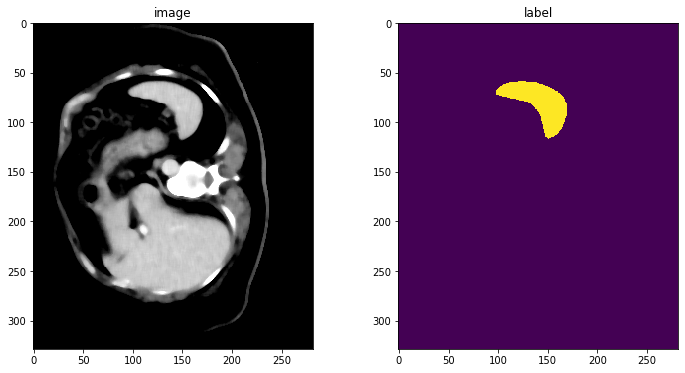

In [21]:
check_ds = monai.data.Dataset(data=data_dicts, transform=transform)
check_loader = monai.data.DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 80], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 80])
plt.show()